<a href="https://colab.research.google.com/github/athxri/MSC/blob/main/CLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

## Load and preprocess the original dataset

In [ ]:
# Set the display format to show two decimal places
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
data = pd.read_json('/content/drive/MyDrive/MSc/raw_customer_data.json', lines=True)

In [ ]:
data.head()

,id,transactions
0,128867,"[{'settledAt': '2022-03-10T14:14:34.583+0000',..."
1,128853,"[{'settledAt': '2022-03-10T11:30:45.292+0000',..."
2,128850,"[{'settledAt': '2022-03-10T11:06:32.510+0000',..."
3,128797,"[{'settledAt': '2022-03-10T08:40:27.015+0000',..."
4,128786,"[{'settledAt': '2022-03-09T17:22:12.586+0000',..."


In [ ]:
# Explode the 'transactions' column to separate rows
data_expanded = data.explode('transactions')

# Normalize the JSON data into separate columns
normalized_data = pd.json_normalize(data_expanded['transactions'])

# Reset index before concatenating
data_expanded.reset_index(drop=True, inplace=True)
normalized_data.reset_index(drop=True, inplace=True)

# Combine the normalized data with the original DataFrame
customers = pd.concat([data_expanded[['id']], normalized_data], axis=1)

customers.head()

,id,settledAt,ftd,amount,status,type
0,128867,2022-03-10T14:14:34.583+0000,True,40.00,SUCCESS,deposit
1,128853,2022-03-10T11:30:45.292+0000,False,50.00,SUCCESS,deposit
2,128853,2022-03-10T09:55:57.469+0000,1.00,50.00,SUCCESS,deposit
3,128850,2022-03-10T11:06:32.510+0000,True,159.00,SUCCESS,deposit
4,128850,2022-03-10T11:32:38.318+0000,0.00,180.00,FAIL,deposit


In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180751 entries, 0 to 180750
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         180751 non-null  int64  
 1   settledAt  180751 non-null  object 
 2   ftd        180751 non-null  object 
 3   amount     180751 non-null  float64
 4   status     180751 non-null  object 
 5   type       180751 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 8.3+ MB


Perfect! we have no empty rows in our columns! Meaning no filling or dropping is needed!

## EDA

Before we start with the EDA we need to sort the dataset by date and Customer ID.
The reason for that is that we need to disregard all transactions that took place before the date of the ftd. Basically for each Customer ID remove all rows before the ftd = True

In [ ]:
#settledAt need to be converted to a datetime format:
customers['settledAt'] = pd.to_datetime(customers['settledAt'])

# Sort the DataFrame by 'id' and 'settledAt'
customers = customers.sort_values(by=['id', 'settledAt'])

#Also we need to convert the ftd column to boolean type
customers['ftd'] = customers['ftd'].astype(bool)

customers.head()

,id,settledAt,ftd,amount,status,type
180750,5774,2019-12-09 10:05:27.783000+00:00,True,50.00,SUCCESS,deposit
180748,5774,2019-12-15 20:09:26.286000+00:00,False,50.00,ERROR,withdrawal
180749,5774,2019-12-16 06:49:49.786000+00:00,False,50.00,SUCCESS,withdrawal
180747,5825,2020-03-20 13:38:59.789000+00:00,False,25.00,FAIL,deposit
180746,5825,2020-03-23 08:26:33.212000+00:00,False,20.00,CANCEL,deposit


Next up we are gonna remove the rows before the ftd = True row for each customer, to do that we are going to filter all the rows that ftd = True for each customer, and perform a left join on the customers df to add the date for each customer. From then on it's easy to compare each row's inequality.

In [ ]:
 # Identify the rows where ftd is True
ftd_rows = customers[customers['ftd']==True]

# Merge the original DataFrame with the ftd_rows to get the date of the first True for each customer
merged_df = pd.merge(customers, ftd_rows[['id', 'settledAt']], on='id', suffixes=('', '_ftd'))

# Keep only the rows where settledAt is greater than or equal to settledAt_ftd
filtered_customers = merged_df[merged_df['settledAt'] >= merged_df['settledAt_ftd']]

# Drop the additional columns used for merging
filtered_customers = filtered_customers.drop(columns=['settledAt_ftd'])

# Display the resulting DataFrame
filtered_customers.shape

(172130, 6)

In [ ]:
filtered_customers.head()

,id,settledAt,ftd,amount,status,type
0,5774,2019-12-09 10:05:27.783000+00:00,True,50.00,SUCCESS,deposit
1,5774,2019-12-15 20:09:26.286000+00:00,False,50.00,ERROR,withdrawal
2,5774,2019-12-16 06:49:49.786000+00:00,False,50.00,SUCCESS,withdrawal
8,5825,2020-03-23 08:48:32.463000+00:00,True,20.00,SUCCESS,deposit
9,5825,2020-03-23 09:31:08.219000+00:00,False,20.00,FAIL,deposit


In [ ]:
filtered_customers[filtered_customers.duplicated()]

,id,settledAt,ftd,amount,status,type
166920,103756,2021-10-12 10:53:18.339000+00:00,True,70.00,SUCCESS,deposit
166921,103756,2021-10-12 10:53:18.339000+00:00,True,70.00,SUCCESS,deposit
166922,103756,2021-10-12 10:53:18.339000+00:00,True,70.00,SUCCESS,deposit
166924,103756,2021-10-29 17:05:34.265000+00:00,False,20.00,FAIL,withdrawal
166925,103756,2021-10-29 17:05:34.265000+00:00,False,20.00,FAIL,withdrawal
...,...,...,...,...,...,...
180921,128853,2022-03-10 11:30:45.292000+00:00,False,50.00,SUCCESS,deposit
180922,128853,2022-03-10 11:30:45.292000+00:00,False,50.00,SUCCESS,deposit
180924,128867,2022-03-10 14:14:34.583000+00:00,True,40.00,SUCCESS,deposit
180925,128867,2022-03-10 14:14:34.583000+00:00,True,40.00,SUCCESS,deposit


So it also looks like we have 190 rows that are duplicates, this should be an error of the transaction log, we will remove the duplicate rows.
Also this is something the company should take a look at as it can inflate the CLV of customers with fabricated values.

In [ ]:
filtered_customers = filtered_customers.drop_duplicates()


### Checking Outliers

In [ ]:
# Summary statistics
print(filtered_customers['amount'].describe())

count    171940.00
mean       1052.84
std        7827.97
min           0.00
25%          20.00
50%          35.00
75%         154.00
max     1144000.00
Name: amount, dtype: float64


First red flag in our data is the max value of the amount column, which is set to a whopping 1,144,000 thus influencing a lot our mean and the std. As we can see the mean is set at around 1000$, the median (50%) is set at 35% and the Standard Deviation is at 7825.

So what we are doing below is to check the distribution on amounts that are on the 95th percentile, since those customers are outliers

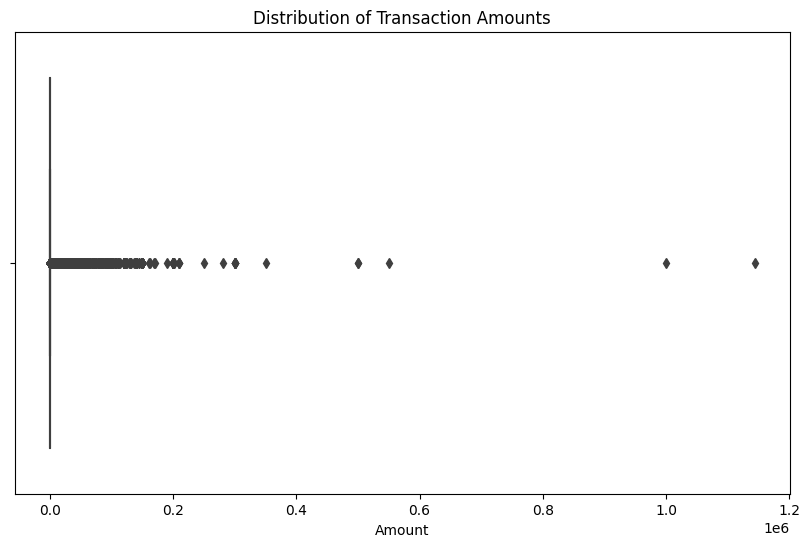

In [ ]:
# Visualize the distribution of amounts using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='amount', data=filtered_customers)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.show()


In [ ]:
# Define a threshold for high-value transactions (e.g., 95th percentile)
threshold = filtered_customers['amount'].quantile(0.95)

# Identify high-value transactions
high_value_transactions = filtered_customers[filtered_customers['amount'] > 100000] # the value is adjusted as needed to check the distributions

# Display information about high-value transactions
len(high_value_transactions)

145

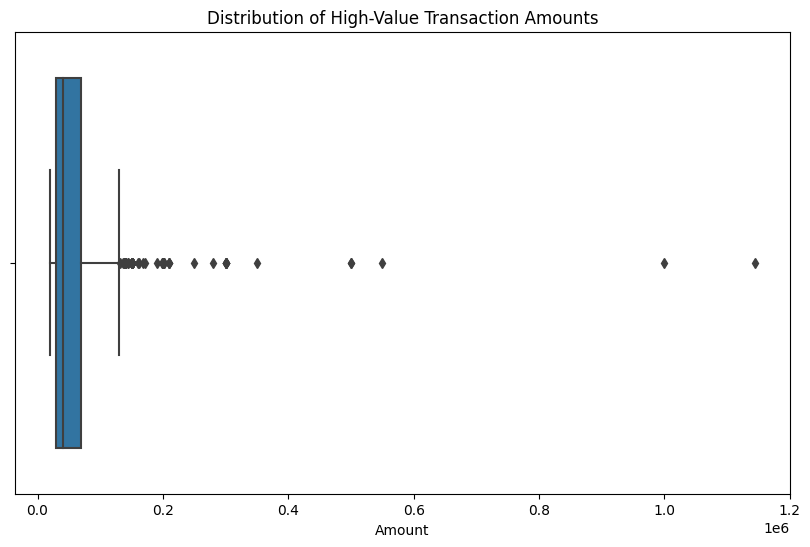

In [ ]:
# Visualize the distribution of high- value amounts using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='amount', data=high_value_transactions)
plt.title('Distribution of High-Value Transaction Amounts')
plt.xlabel('Amount')
plt.show()

In [ ]:
# Identify high-value transactions
low_value_transactions = filtered_customers[filtered_customers['amount'] < 175] # the value is adjusted as needed to check the distributions

# Display information about high-value transactions
len(low_value_transactions)

129974

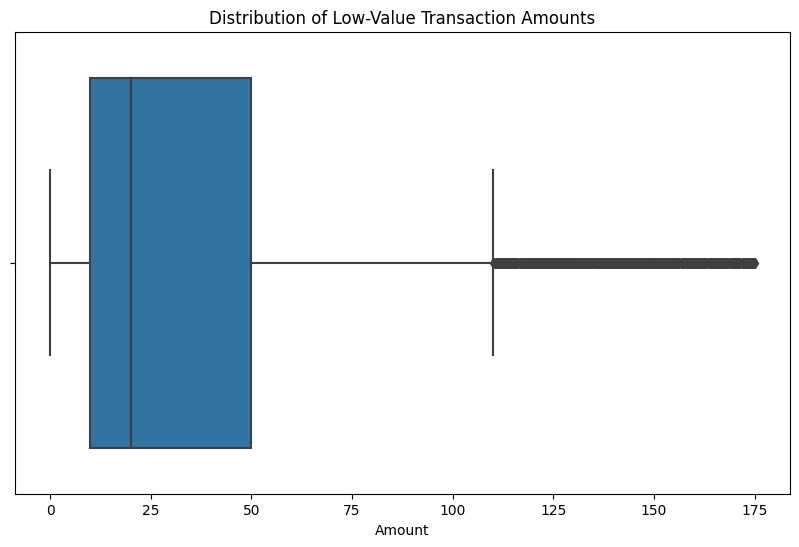

In [ ]:
# Visualize the distribution of low - value amounts using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='amount', data=low_value_transactions)
plt.title('Distribution of Low-Value Transaction Amounts')
plt.xlabel('Amount')
plt.show()

Considering that we have a lot of extreme values (in comparison with the median) it makes no sense to remove customers with very high amounts, as these will be the customers with the highest CLV

In [ ]:
# Calculate the IQR
Q1 = filtered_customers['amount'].quantile(0.25)
Q3 = filtered_customers['amount'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = filtered_customers[(filtered_customers['amount'] < (Q1 - 1.5 * IQR)) | (filtered_customers['amount'] > (Q3 + 1.5 * IQR))]

# Examine the details of outliers
outliers


,id,settledAt,ftd,amount,status,type
110,5857,2021-03-16 03:55:21.222000+00:00,True,5000.00,SUCCESS,deposit
111,5857,2021-03-17 19:04:36.832000+00:00,False,1900.00,SUCCESS,withdrawal
112,5857,2021-03-17 19:08:24.514000+00:00,False,2200.00,SUCCESS,deposit
113,5857,2021-09-28 04:14:48.761000+00:00,False,3100.00,CANCEL,deposit
114,5857,2021-09-28 04:17:40.154000+00:00,False,3100.00,SUCCESS,deposit
...,...,...,...,...,...,...
180831,128496,2022-03-11 06:56:45.129000+00:00,False,1200.00,CANCEL,deposit
180835,128496,2022-03-11 06:57:34.634000+00:00,False,1200.00,CANCEL,deposit
180839,128496,2022-03-11 07:00:53.476000+00:00,False,1200.00,SUCCESS,deposit
180843,128496,2022-03-11 08:46:28.096000+00:00,False,1793.00,SUCCESS,transfer


In [ ]:
outliers.status.value_counts()

SUCCESS    22244
FAIL        4915
CANCEL      3341
ERROR       1035
INITIAL        1
Name: status, dtype: int64

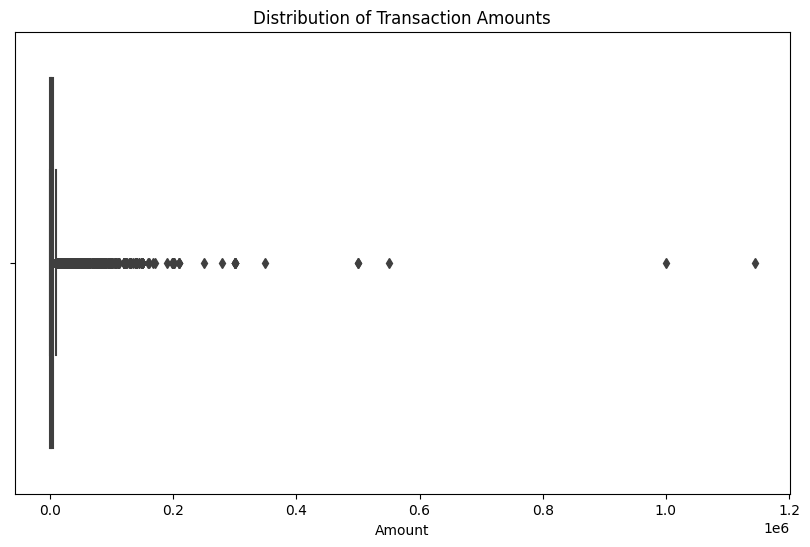

In [ ]:
# Visualize the distribution of amounts using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='amount', data=outliers)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.show()


In [ ]:
# Identify high-value transactions (adjust threshold as needed)
high_value_threshold = 500000
high_value_transactions = filtered_customers[filtered_customers['amount'] > high_value_threshold]

# Analyze the behavior of customers with high-value transactions
high_value_summary = high_value_transactions.groupby('id')['amount'].agg(['count', 'mean', 'max'])
high_value_summary

,count,mean,max
id,,,
14309,1,1144000.00,1144000.00
17747,1,1000000.00,1000000.00
62378,1,550000.00,550000.00


As we can see with the threshold here we have customers who engage in very high value transactions, we should create a new column to identify:
- customers with large amounts of transactions
- customers with many transactions (loyal customers)
- customers with too few transactions

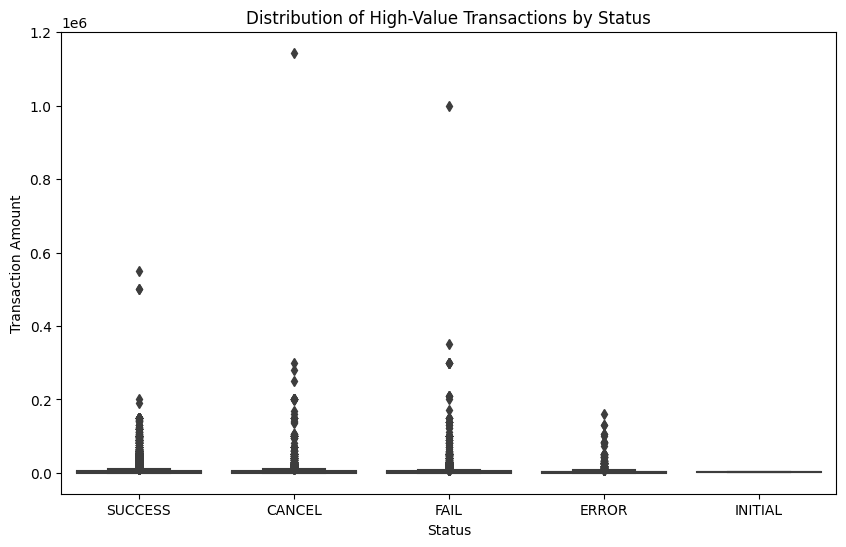

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='status', y='amount', data=outliers)
plt.title('Distribution of High-Value Transactions by Status')
plt.xlabel('Status')
plt.ylabel('Transaction Amount')
plt.show()


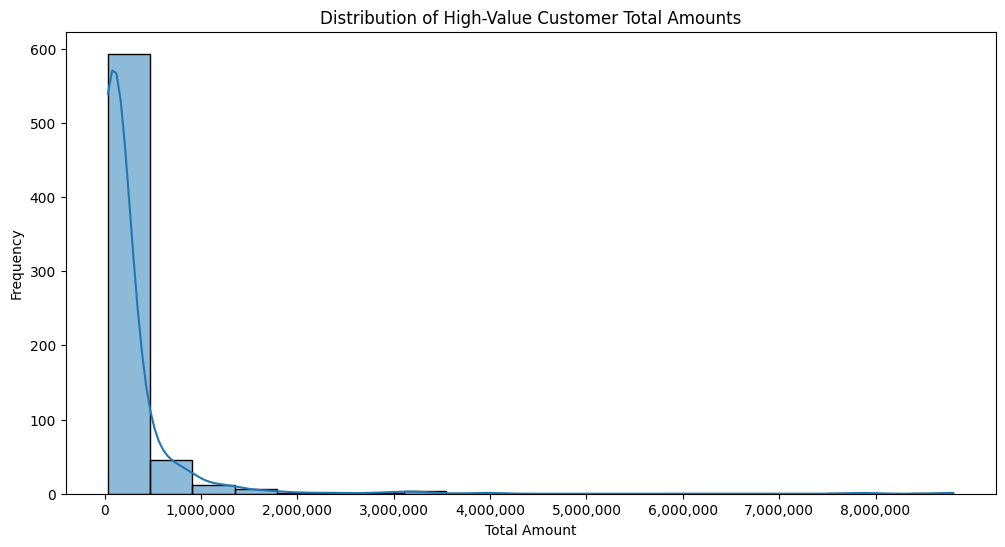

Average Transaction Amount for High-Value Customers: 3228.7606750287823
Average Transaction Frequency for High-Value Customers: 74.33783783783784


In [ ]:
import matplotlib.ticker as ticker

# Calculate the total transaction amount for each customer
customer_total_amount = filtered_customers.groupby('id')['amount'].sum().reset_index(name='total_amount')

# Define a threshold for high-value customers
threshold = customer_total_amount['total_amount'].quantile(0.9)# here we added the top 10%

# Identify high-value customers
high_value_customers = customer_total_amount[customer_total_amount['total_amount'] > threshold]

# Merge with the original data to get detailed information about high-value customers
high_value_customer_details = pd.merge(high_value_customers, filtered_customers, on='id')

# Visualize high-value customer distribution
plt.figure(figsize=(12, 6))
sns.histplot(high_value_customers['total_amount'], bins=20, kde=True)

# Format x-axis tick labels in normal scale
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Set custom ticks every 500,000
custom_ticks = np.arange(0, high_value_customer_details['total_amount'].max(), 1000000)
plt.xticks(custom_ticks)

plt.title('Distribution of High-Value Customer Total Amounts')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.show()

# Analyze other aspects of high-value customer behavior based on your data

# Example: Average transaction amount for high-value customers
avg_amount_high_value = high_value_customer_details['amount'].mean()
print(f'Average Transaction Amount for High-Value Customers: {avg_amount_high_value}')

# Example: Frequency of transactions for high-value customers
transaction_frequency_high_value = high_value_customer_details.groupby('id').size().mean()
print(f'Average Transaction Frequency for High-Value Customers: {transaction_frequency_high_value}')

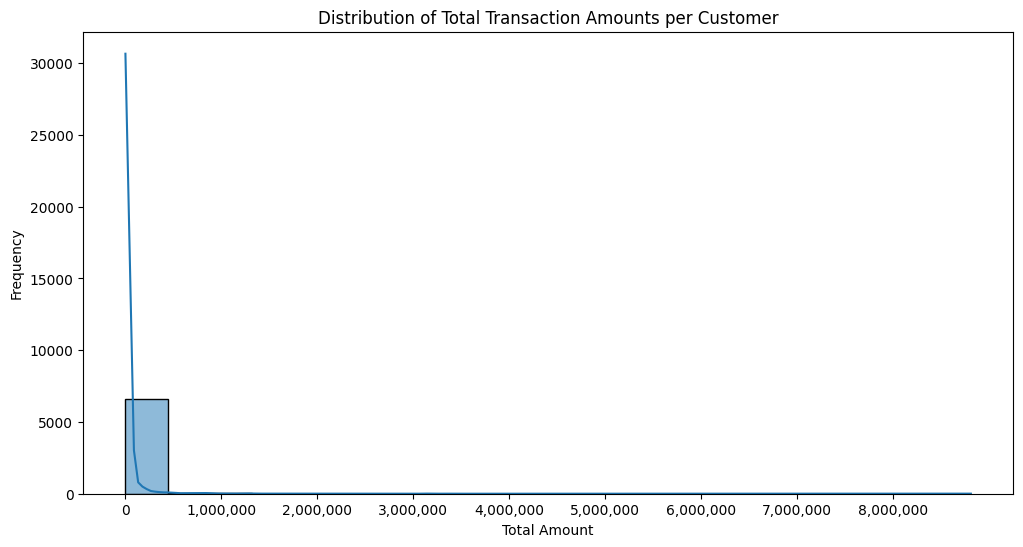

In [ ]:
# Visualize the distribution of total transaction amount
plt.figure(figsize=(12, 6))
sns.histplot(customer_total_amount['total_amount'], bins=20, kde=True)

# Format x-axis tick labels in normal scale
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Set custom ticks every 100,000
custom_ticks = np.arange(0, customer_total_amount['total_amount'].max(), 1000000)
plt.xticks(custom_ticks)

plt.title('Distribution of Total Transaction Amounts per Customer')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.show()

In [ ]:
high_value_customers

,id,total_amount
8,5857,59418.00
11,5883,60000.00
23,5945,67806.58
40,6052,60356.08
43,6067,47775.32
...,...,...
6602,122929,58361.00
6631,126651,50000.00
6639,126950,62860.00
6647,127150,75000.00


In [ ]:
high_value_customer_details

,id,total_amount,settledAt,ftd,amount,status,type
0,5857,59418.00,2021-03-16 03:55:21.222000+00:00,True,5000.00,SUCCESS,deposit
1,5857,59418.00,2021-03-17 19:04:36.832000+00:00,False,1900.00,SUCCESS,withdrawal
2,5857,59418.00,2021-03-17 19:08:24.514000+00:00,False,2200.00,SUCCESS,deposit
3,5857,59418.00,2021-09-28 04:14:48.761000+00:00,False,3100.00,CANCEL,deposit
4,5857,59418.00,2021-09-28 04:17:40.154000+00:00,False,3100.00,SUCCESS,deposit
...,...,...,...,...,...,...,...
49504,127275,63487.00,2022-03-09 08:02:39.229000+00:00,False,10000.00,SUCCESS,transfer
49505,127275,63487.00,2022-03-09 11:59:11.628000+00:00,False,2500.00,SUCCESS,deposit
49506,127275,63487.00,2022-03-09 12:17:20.972000+00:00,False,2500.00,FAIL,deposit
49507,127275,63487.00,2022-03-11 06:46:40.393000+00:00,False,10000.00,SUCCESS,deposit


### Timeseries plots

Next up lets check the seasonality and trend of the amount column on a monthly basis

<ipython-input-22-1aa397f48192>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_customers['month'] = filtered_customers['settledAt'].dt.to_period('M')


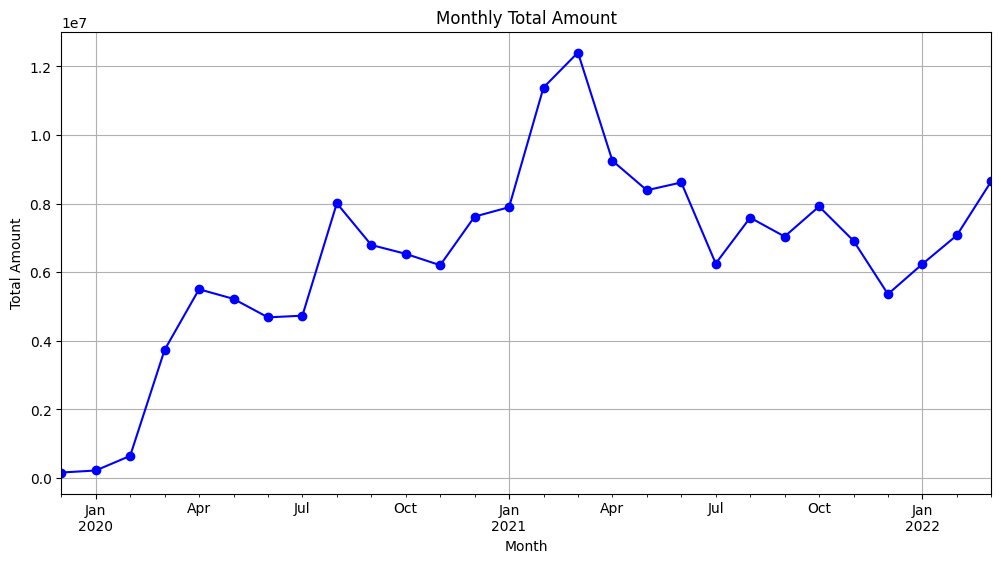

In [ ]:
# Extract month from 'settledAt'
filtered_customers['month'] = filtered_customers['settledAt'].dt.to_period('M')

# Group by month and sum the 'amount'
monthly_amount = filtered_customers.groupby('month')['amount'].sum()

# Plot the time series
plt.figure(figsize=(12, 6))
monthly_amount.plot(marker='o', linestyle='-', color='b')
plt.title('Monthly Total Amount')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.grid(True)
plt.show()

 Overall it sees that the total amount of transactions is following a rising trend, signaling a healthy growth for the company.

In [ ]:
filtered_customers.loc[(filtered_customers['settledAt'] >= '2021-02-01') & (filtered_customers['settledAt'] < '2021-04-01')]

,id,settledAt,ftd,amount,status,type,month
110,5857,2021-03-16 03:55:21.222000+00:00,True,5000.00,SUCCESS,deposit,2021-03
111,5857,2021-03-17 19:04:36.832000+00:00,False,1900.00,SUCCESS,withdrawal,2021-03
112,5857,2021-03-17 19:08:24.514000+00:00,False,2200.00,SUCCESS,deposit,2021-03
156,5868,2021-03-05 09:03:54.203000+00:00,False,125.00,CANCEL,deposit,2021-03
157,5868,2021-03-05 09:06:55.053000+00:00,False,125.00,CANCEL,deposit,2021-03
...,...,...,...,...,...,...,...
148289,87568,2021-03-30 19:37:00.793000+00:00,False,370.00,CANCEL,deposit,2021-03
148290,87568,2021-03-30 19:41:55.577000+00:00,False,370.00,SUCCESS,deposit,2021-03
148291,87568,2021-03-31 02:56:58.592000+00:00,False,1088.00,CANCEL,deposit,2021-03
148292,87568,2021-03-31 03:01:17.176000+00:00,False,1088.00,SUCCESS,deposit,2021-03


Weekly plot

<ipython-input-24-c1aa8c2e96dc>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_customers['week'] = filtered_customers['settledAt'].dt.to_period('W-Mon')


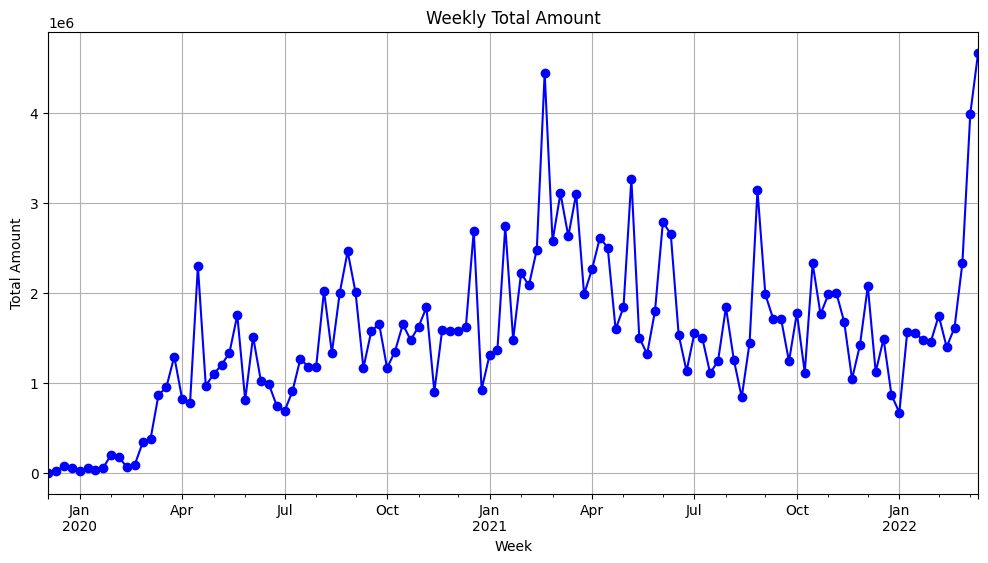

In [ ]:
# Extract week from 'settledAt'
filtered_customers['week'] = filtered_customers['settledAt'].dt.to_period('W-Mon')

# Group by week and sum the 'amount'
weekly_amount = filtered_customers.groupby('week')['amount'].sum()

# Plot the time series
plt.figure(figsize=(12, 6))
weekly_amount.plot(marker='o', linestyle='-', color='b')
plt.title('Weekly Total Amount')
plt.xlabel('Week')
plt.ylabel('Total Amount')
plt.grid(True)
plt.show()

INFO ABOUT ABOVE TBD

Daily timeseries chart:

<ipython-input-25-a992db881660>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='day', y='amount', data=filtered_customers, estimator='sum', ci=None, sort=False)


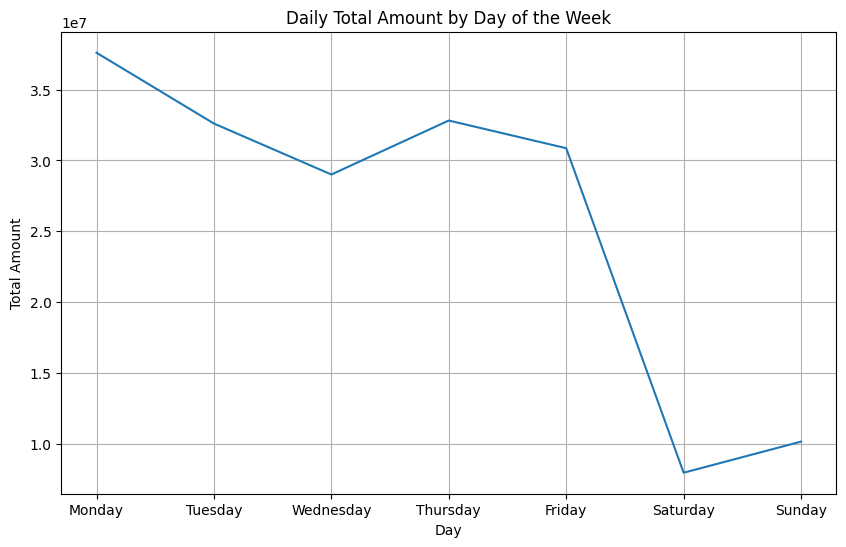

In [ ]:
# Extract weekday from 'settledAt'
filtered_customers = filtered_customers.sort_values(by=['settledAt'])
filtered_customers['day'] = filtered_customers['settledAt'].dt.day_name()

# Set the order of days
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
filtered_customers['day'] = pd.Categorical(filtered_customers['day'], categories=order, ordered=True)

# Plot the time series using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='day', y='amount', data=filtered_customers, estimator='sum', ci=None, sort=False)
plt.title('Daily Total Amount by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.grid(True)
plt.show()

So it seems that trasaction amount is peaking every monday, with a continuous drop and a small rise every Thursday

### Relationships

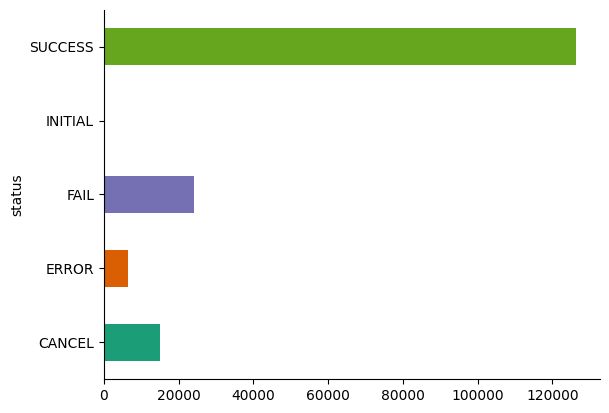

In [ ]:
filtered_customers.groupby('status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

So most of the transactions are classified as success, we will investigate the Fails/Errors/Cancels and their possible connections to the type and amount columns.

In [ ]:
filtered_customers['type'].value_counts()

deposit       84182
withdrawal    81182
transfer       6576
Name: type, dtype: int64

In [ ]:
filtered_customers['status'].value_counts()

SUCCESS    126391
FAIL        24087
CANCEL      14898
ERROR        6558
INITIAL         6
Name: status, dtype: int64

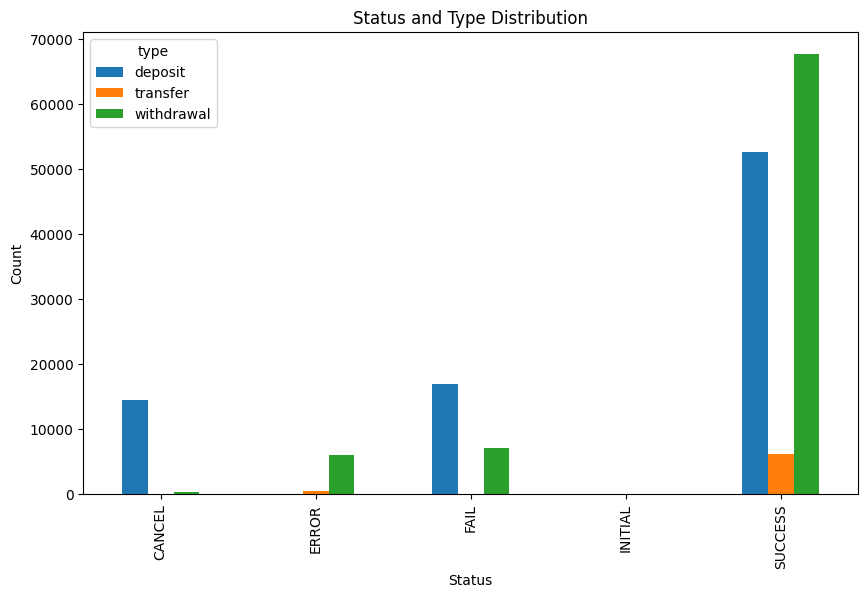

In [ ]:
# Select columns to plot
columns_to_plot = ['status', 'type']

# Plot the selected columns
filtered_customers[columns_to_plot].value_counts().unstack().plot(kind='bar', figsize=(10, 6))

# Set plot labels and title
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Status and Type Distribution')

# Show the plot
plt.show()

It seems that most of the "negative" results are happening during deposits.
We would suggest MORE ATTENTION TO DEPOSITS, BETTER INFO TO CUSTOMERS? REVIEW LOGS?

In [ ]:
filtered_customers.head()

,id,settledAt,ftd,amount,status,type,month,week,day
276,5905,2019-12-09 09:00:28.745000+00:00,True,30.00,SUCCESS,deposit,2019-12,2019-12-03/2019-12-09,Monday
277,5905,2019-12-09 09:04:58.672000+00:00,False,30.00,FAIL,deposit,2019-12,2019-12-03/2019-12-09,Monday
278,5905,2019-12-09 09:05:07.505000+00:00,False,30.00,FAIL,deposit,2019-12,2019-12-03/2019-12-09,Monday
0,5774,2019-12-09 10:05:27.783000+00:00,True,50.00,SUCCESS,deposit,2019-12,2019-12-03/2019-12-09,Monday
421,5924,2019-12-09 12:08:21.516000+00:00,True,180.00,SUCCESS,deposit,2019-12,2019-12-03/2019-12-09,Monday


ABOVE IS NO USE

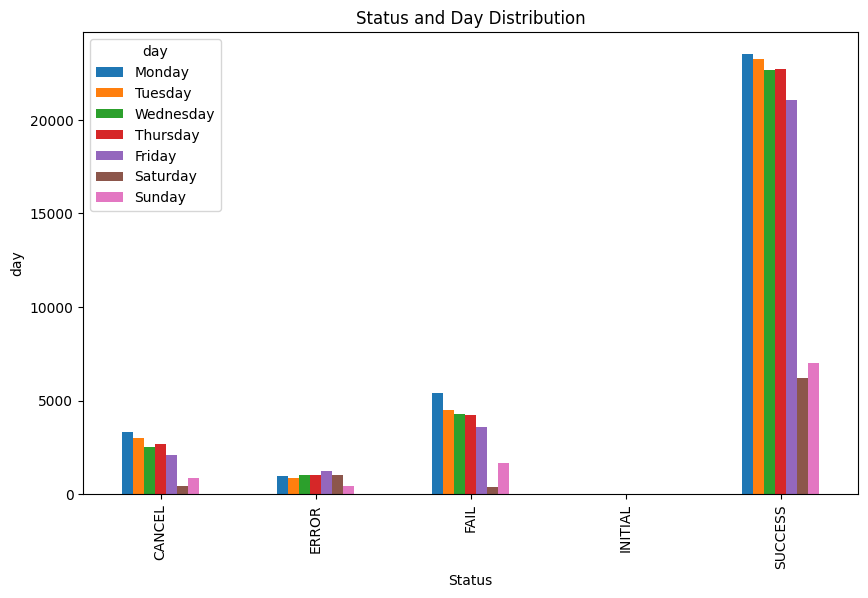

In [ ]:
# Select columns to plot
columns_to_plot = ['status', 'day']

# Plot the selected columns
filtered_customers[columns_to_plot].value_counts().unstack().plot(kind='bar', figsize=(10, 6))

# Set plot labels and title
plt.xlabel('Status')
plt.ylabel('day')
plt.title('Status and Day Distribution')

# Show the plot
plt.show()

In [ ]:
filtered_customers.head()

,id,settledAt,ftd,amount,status,type,month,week,day
276,5905,2019-12-09 09:00:28.745000+00:00,True,30.00,SUCCESS,deposit,2019-12,2019-12-03/2019-12-09,Monday
277,5905,2019-12-09 09:04:58.672000+00:00,False,30.00,FAIL,deposit,2019-12,2019-12-03/2019-12-09,Monday
278,5905,2019-12-09 09:05:07.505000+00:00,False,30.00,FAIL,deposit,2019-12,2019-12-03/2019-12-09,Monday
0,5774,2019-12-09 10:05:27.783000+00:00,True,50.00,SUCCESS,deposit,2019-12,2019-12-03/2019-12-09,Monday
421,5924,2019-12-09 12:08:21.516000+00:00,True,180.00,SUCCESS,deposit,2019-12,2019-12-03/2019-12-09,Monday


In [ ]:
# Assuming your filtered DataFrame is named filtered_customers
median_amount_by_type = filtered_customers.groupby('type')['amount'].median()

# Display the median amount for each type
print(median_amount_by_type)


type
deposit      50.00
transfer     32.55
withdrawal   20.00
Name: amount, dtype: float64


In [ ]:
# Assuming your filtered DataFrame is named filtered_customers
mean_amount_by_status = filtered_customers.groupby('status')['amount'].mean()

# Display the median amount for each type
print(mean_amount_by_status)


status
CANCEL    1657.23
ERROR      841.81
FAIL      1234.34
INITIAL    519.94
SUCCESS    957.98
Name: amount, dtype: float64


## MODEL

In [ ]:
import pandas as pd

def preprocess_data(file_path, start_date=None, end_date=None):
    # Read the raw data
    data = pd.read_json(file_path, lines=True)

    # Explode the 'transactions' column to separate rows
    data_expanded = data.explode('transactions')

    # Normalize the JSON data into separate columns
    normalized_data = pd.json_normalize(data_expanded['transactions'])

    # Reset index before concatenating
    data_expanded.reset_index(drop=True, inplace=True)
    normalized_data.reset_index(drop=True, inplace=True)

    # Combine the normalized data with the original DataFrame
    preprocessed_data = pd.concat([data_expanded[['id']], normalized_data], axis=1)

    # Convert 'settledAt' to datetime format
    preprocessed_data['settledAt'] = pd.to_datetime(preprocessed_data['settledAt'])

    # Sort the DataFrame by 'id' and 'settledAt'
    preprocessed_data = preprocessed_data.sort_values(by=['id', 'settledAt'])

    # Convert the 'ftd' column to boolean type
    preprocessed_data['ftd'] = preprocessed_data['ftd'].astype(bool)

    # Filter data based on the specified timeframe
    if start_date and end_date:
        preprocessed_data = preprocessed_data[(preprocessed_data['settledAt'] >= start_date) &
                                              (preprocessed_data['settledAt'] <= end_date)]

    # Identify the rows where ftd is True
    ftd_rows = preprocessed_data[preprocessed_data['ftd'] == True]

    # Merge the original DataFrame with the ftd_rows to get the date of the first True for each customer
    merged_df = pd.merge(preprocessed_data, ftd_rows[['id', 'settledAt']], on='id', suffixes=('', '_ftd'))

    # Calculate CLV by multiplying the sum of transactions with the transaction value
    merged_df['clv'] = merged_df.groupby('id')['amount'].transform('sum') * \
                      merged_df.groupby('id')['amount'].transform('count')

    # Keep only the rows where settledAt is greater than or equal to settledAt_ftd
    filtered_customers = merged_df[merged_df['settledAt'] >= merged_df['settledAt_ftd']]

    # Drop the additional columns used for merging
    filtered_customers = filtered_customers.drop(columns=['settledAt_ftd'])

    # Drop duplicates
    filtered_customers = filtered_customers.drop_duplicates()

    return filtered_customers

# Example usage for a specific timeframe (June 2019 to July 2019)
start_date = None
end_date = None
raw_data_path = '/content/drive/MyDrive/MSc/raw_customer_data.json'
preprocessed_data = preprocess_data(raw_data_path, start_date, end_date)


In [ ]:
preprocessed_data.head()

,id,settledAt,ftd,amount,status,type,clv
0,5774,2019-12-09 10:05:27.783000+00:00,True,50.0,SUCCESS,deposit,450.0
1,5774,2019-12-15 20:09:26.286000+00:00,False,50.0,ERROR,withdrawal,450.0
2,5774,2019-12-16 06:49:49.786000+00:00,False,50.0,SUCCESS,withdrawal,450.0
8,5825,2020-03-23 08:48:32.463000+00:00,True,20.0,SUCCESS,deposit,1539.0
9,5825,2020-03-23 09:31:08.219000+00:00,False,20.0,FAIL,deposit,1539.0


In [ ]:
import pandas as pd

def preprocess_data(file_path, start_date=None, end_date=None):
    # Load the data
    data = pd.read_json(file_path, lines=True)

    # Explode the 'transactions' column to separate rows
    data_expanded = data.explode('transactions')

    # Normalize the JSON data into separate columns
    normalized_data = pd.json_normalize(data_expanded['transactions'])

    # Reset index before concatenating
    data_expanded.reset_index(drop=True, inplace=True)
    normalized_data.reset_index(drop=True, inplace=True)

    # Combine the normalized data with the original DataFrame
    customers = pd.concat([data_expanded[['id']], normalized_data], axis=1)

    # Convert 'settledAt' to datetime format
    customers['settledAt'] = pd.to_datetime(customers['settledAt'])

    # Sort the DataFrame by 'id' and 'settledAt'
    customers = customers.sort_values(by=['id', 'settledAt'])

    # Convert 'ftd' column to boolean type
    customers['ftd'] = customers['ftd'].astype(bool)

    # Filter data based on start_date and end_date
    if start_date and end_date:
        customers = customers[(customers['settledAt'] >= start_date) & (customers['settledAt'] <= end_date)]

    # Identify the rows where ftd is True
    ftd_rows = customers[customers['ftd'] == True]

    # Merge the original DataFrame with the ftd_rows to get the date of the first True for each customer
    merged_df = pd.merge(customers, ftd_rows[['id', 'settledAt']], on='id', suffixes=('', '_ftd'))

    # Keep only the rows where settledAt is greater than or equal to settledAt_ftd
    filtered_customers = merged_df[merged_df['settledAt'] >= merged_df['settledAt_ftd']]

    # Drop the additional columns used for merging
    filtered_customers = filtered_customers.drop(columns=['settledAt_ftd'])

    # Aggregate data for each customer
    aggregated_data = filtered_customers.groupby(['id']).agg(
        clv=('amount', 'sum'),
        transaction_count=('id', 'count'),
        deposit=('type', lambda x: (x == 'deposit').sum()),
        withdrawal=('type', lambda x: (x == 'withdrawal').sum()),
        transfer=('type', lambda x: (x == 'transfer').sum())
    ).reset_index()

    # Print relevant information for troubleshooting
    print("Number of rows after aggregation:", len(aggregated_data))
    print(aggregated_data.head())

    return aggregated_data

# Example usage
preprocessed_data = preprocess_data('/content/drive/MyDrive/MSc/raw_customer_data.json', start_date=None, end_date=None)
preprocessed_data.head()

Number of rows after aggregation: 6661
     id      clv  transaction_count  deposit  withdrawal  transfer
0  5774   150.00                  3        1           2         0
1  5825    66.00                  4        3           1         0
2  5830   200.00                  2        2           0         0
3  5838  1635.77                 33       22          11         0
4  5839  1016.68                 35       19           0        16


,id,clv,transaction_count,deposit,withdrawal,transfer
0,5774,150.00,3,1,2,0
1,5825,66.00,4,3,1,0
2,5830,200.00,2,2,0,0
3,5838,1635.77,33,22,11,0
4,5839,1016.68,35,19,0,16


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def split_data(data):
    # Split data into training and testing sets
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    return train_data, test_data

def hyperparameter_tuning(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    return best_model

def train_CLV(calibration_data):
    # Hyperparameter tuning
    X = calibration_data.drop(['id', 'clv'], axis=1)
    y = calibration_data['clv']

    best_model = hyperparameter_tuning(X, y)

    # Train the model with the best hyperparameters
    best_model.fit(X, y)

    return best_model

def infer_CLV(observation_data, model):
    # Assuming 'clv' is the target variable, and other columns are features
    X_observation = observation_data.drop(['id', 'clv'], axis=1)

    # Run inference
    predicted_clv = model.predict(X_observation)

    # Attach the predictions to the observation_data DataFrame
    observation_data['predicted_clv'] = predicted_clv

    return observation_data

def root_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def evaluate_CLV(pred_CLV, actual_CLV):
    # Assuming 'clv' is the true CLV and 'predicted_clv' is the predicted CLV
    rmse = root_mean_squared_error(actual_CLV['clv'], pred_CLV['predicted_clv'])

    return rmse

# Run
train_data, test_data = split_data(preprocessed_data)
calibration_model = train_CLV(train_data)
predicted_data = infer_CLV(test_data, calibration_model)
evaluation_result = evaluate_CLV(predicted_data, test_data)

print("Root Mean Squared Error:", evaluation_result)


Root Mean Squared Error: 137376.16800009846
